In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import documents as docs
import textcomparisons as tc
from collections import Counter
import random

data_folder = "data"
spotify_file = "spotify_articles.csv"
spotify_path = os.path.join(data_folder, spotify_file)

census_file = "census_articles.csv"
census_path = os.path.join(data_folder, census_file)

helsinki_file = "helsinki_articles.csv"
helsinki_path = os.path.join(data_folder, helsinki_file)

In [2]:
def cleanArticle(article, sep = "###", n = 3):
    """ Given a scraped article, splits it into paragraphs by sep, and 
    removes paragraphs n words and under. Returns the article with 
    newlines between paragraphs
    """
    paras = article.split(sep)
    paras = [para for para in paras if len(para.split()) > n]
    return("\n".join(paras))

def readArticles(path):
    """ Reads df of articles from the given path, and adds a column
    to store the Document-processed article """
    article_df = pd.read_csv(path)
    article_df["doc"] = None
    return article_df

def dict_by_ids(df, ids):
    """ Given a dataframe of articles and a list of article ids, 
    returns a dictionary with ids as keys and Documents as items, 
    computing and storing the Documents back in the df as needed
    """
    doc_dict = {}
    for doc_id in ids:
        row = df["id"] == doc_id
        doc = df.loc[row, "doc"].iloc[0]
        if doc is None:
            doc = docs.Document(df.loc[row, "text"].iloc[0], clean = False)
            df.loc[row, "doc"] = doc
        doc_dict[doc_id] = doc
    return doc_dict

spotify_df = readArticles(spotify_path)
census_df = readArticles(census_path)
helsinki_df = readArticles(helsinki_path)

dict_by_ids(helsinki_df, [6])
helsinki_df.head()

,id,publisher,scrape_time,text,doc
0,6,nytimes.com,2018-07-15T07:54:28-04:00,Trump Plays Golf in Scotland Before Putin Summ...,Trump Plays Golf in Scotland Before Putin Summ...
1,35,dailymail.co.uk,2018-07-15T06:34:13-04:00,"Sunday, Jul 15th 2018 5-Day Forecast ### Adver...",None
2,57,newyorker.com,2018-07-16T09:10:56-04:00,Will Putin Spare Trump the Lecture He Has Give...,None
3,77,oregonlive.com,2018-07-16T10:19:40-04:00,Enter City and State or Zip Code ### Congratul...,None
4,106,bostonglobe.com,2018-07-16T03:33:28-04:00,The Boston Globe ### Scroll to top of page ###...,None


In [3]:
clust_levinson = [610, 3581, 6678]
clust_reuters = [761, 16223]
clust_ap = [8200, 8818, 9990]
clust_ap_files = [12769, 2313, 6190]
clust_freshair = [7042, 6644]
unique = [6754, 10053, 10250, 6146, 967, 15307, 15482, 604, 1766, 4738, 5906, 6844, 14721, 14730]
clust_wrong = [10254, 9090]
clust_snippet = [7624, 8985, 5289]
# 7624 = paraphrase of AP
# 8985 = briefing of many news stories, includes snippet from 6844
# 967 = not exactly copied from, but heavily based off of the original NYT report 
# 1766 = heavily based off of reuters 

In [4]:
ac = tc.ArticleComparisons()

doc_r1 = docs.Document(census_df[census_df["id"] == 761].iloc[0, 3], clean = False)
doc_r2 = docs.Document(census_df[census_df["id"] == 16223].iloc[0, 3], clean = False)
doc_ap1 = docs.Document(census_df[census_df["id"] == 8200].iloc[0, 3], clean = False)
doc_ap2 = docs.Document(census_df[census_df["id"] == 8818].iloc[0, 3], clean = False)
doc_w = docs.Document(census_df[census_df["id"] == 10254].iloc[0, 3], clean = False)

doc_6844 = docs.Document(census_df[census_df["id"] == 6844].iloc[0, 3], clean = False)
snip_6844 = docs.Document(census_df[census_df["id"] == 8985].iloc[0, 3], clean = False)

Text(0.5, 1.0, 'Probability density histograms of pairwise sentence Jaccard indices')

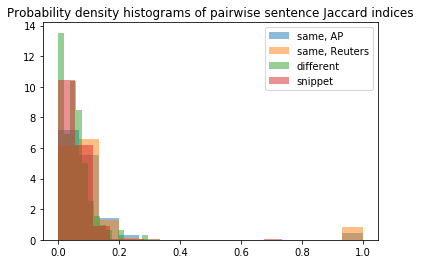

In [5]:
def hist(mat, density = True, alpha = 0.5, bins = 15):
    if len(np.shape(mat)) > 1:
        mat = tc.flatten(mat)
    plt.hist(mat, density = density, alpha = alpha, bins = bins)

# example of pairwise sentence jaccard indices between two unique files, vs. two "identical" files 

hist(ac.get_jaccard_matrix(doc_ap1, doc_ap2))
hist(ac.get_jaccard_matrix(doc_r1, doc_r2))
hist(ac.get_jaccard_matrix(doc_r1, doc_w))
hist(ac.get_jaccard_matrix(doc_6844, snip_6844))
plt.legend(["same, AP", "same, Reuters", "different", "snippet"])
plt.title("Probability density histograms of pairwise sentence Jaccard indices")

C:\Users\v-lindo\anaconda3\lib\site-packages\numpy\lib\histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5, 1.0, 'Probability density histograms of matched sentence Jaccard indices\n (with threshold = 0.5)')

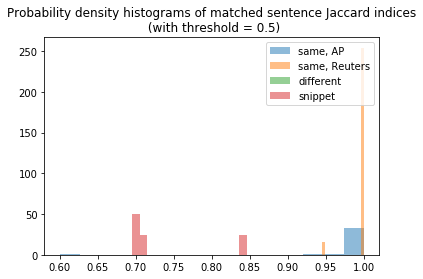

In [6]:
# example of pairwise sentence jaccard indices between two unique files, vs. two "identical" files 
hist(ac.get_jaccard_matrix(doc_ap1, doc_ap2)[np.where(ac.get_match_matrix() > 0)])
hist(ac.get_jaccard_matrix(doc_r1, doc_r2)[np.where(ac.get_match_matrix() > 0)])
hist(ac.get_jaccard_matrix(doc_r1, doc_w)[np.where(ac.get_match_matrix() > 0)])
hist(ac.get_jaccard_matrix(doc_6844, snip_6844)[np.where(ac.get_match_matrix() > 0)])
plt.legend(["same, AP", "same, Reuters", "different", "snippet"])
plt.title("Probability density histograms of matched sentence Jaccard indices\n (with threshold = 0.5)")

In [7]:
jac_mat_snip = ac.get_jaccard_matrix(doc_6844, snip_6844)
match_mat_snip = ac.get_match_matrix()
#ac.display_mat(match_mat_snip)

print("Similarity score", ac.jaccard_score(), "| Unweighted", np.sum(jac_mat_snip * match_mat_snip))
ac.print_sentence_matches()

Similarity score 0.08426864096355621 | Unweighted 2.9494024337244675
S 0 :  Immigration activists rallied outside the Supreme Court in April as the justices heard arguments over the Trump administration's plan to ask about citizenship on the 2020 census.(J. 

	T 53 0.85 :  Immigration activists rally outside the Supreme Court as the justices hear arguments over the Trump administration's plan to ask about citizenship on the 2020 census, in Washington. 

S 2 :  WASHINGTON — Just weeks before the Supreme Court is expected to rule on whether the Trump administration can add a citizenship question to the 2020 census, new evidence emerged Thursday suggesting that the question was crafted specifically to give an electoral advantage to white Republicans. 

	T 56 0.71 :  BOMBSHELL DEVELOPMENT IN CENSUS CASE: "Just weeks before the Supreme Court is expected to rule on whether the Trump administration can add a citizenship question to the 2020 Census, new evidence emerged Thursday suggesting the

In [8]:
bow1 = doc_6844.get_bow_sentences()[1]
bow2 = snip_6844.get_bow_sentences()[55]
ac.jaccard_index(bow1, bow2, visualize = True)

Jaccard Index: 0.3333333333333333 with counts False
I: {'applewhit', 'scott'}
A-B: {'2019', 'press', 'associ', 'file'} 
B-A: set()


0.3333333333333333

0 / 17 done, 0.0 seconds elapsed
2 / 17 done, 1.06 seconds elapsed
7 / 17 done, 3.51 seconds elapsed
12 / 17 done, 8.46 seconds elapsed
14 / 17 done, 8.57 seconds elapsed


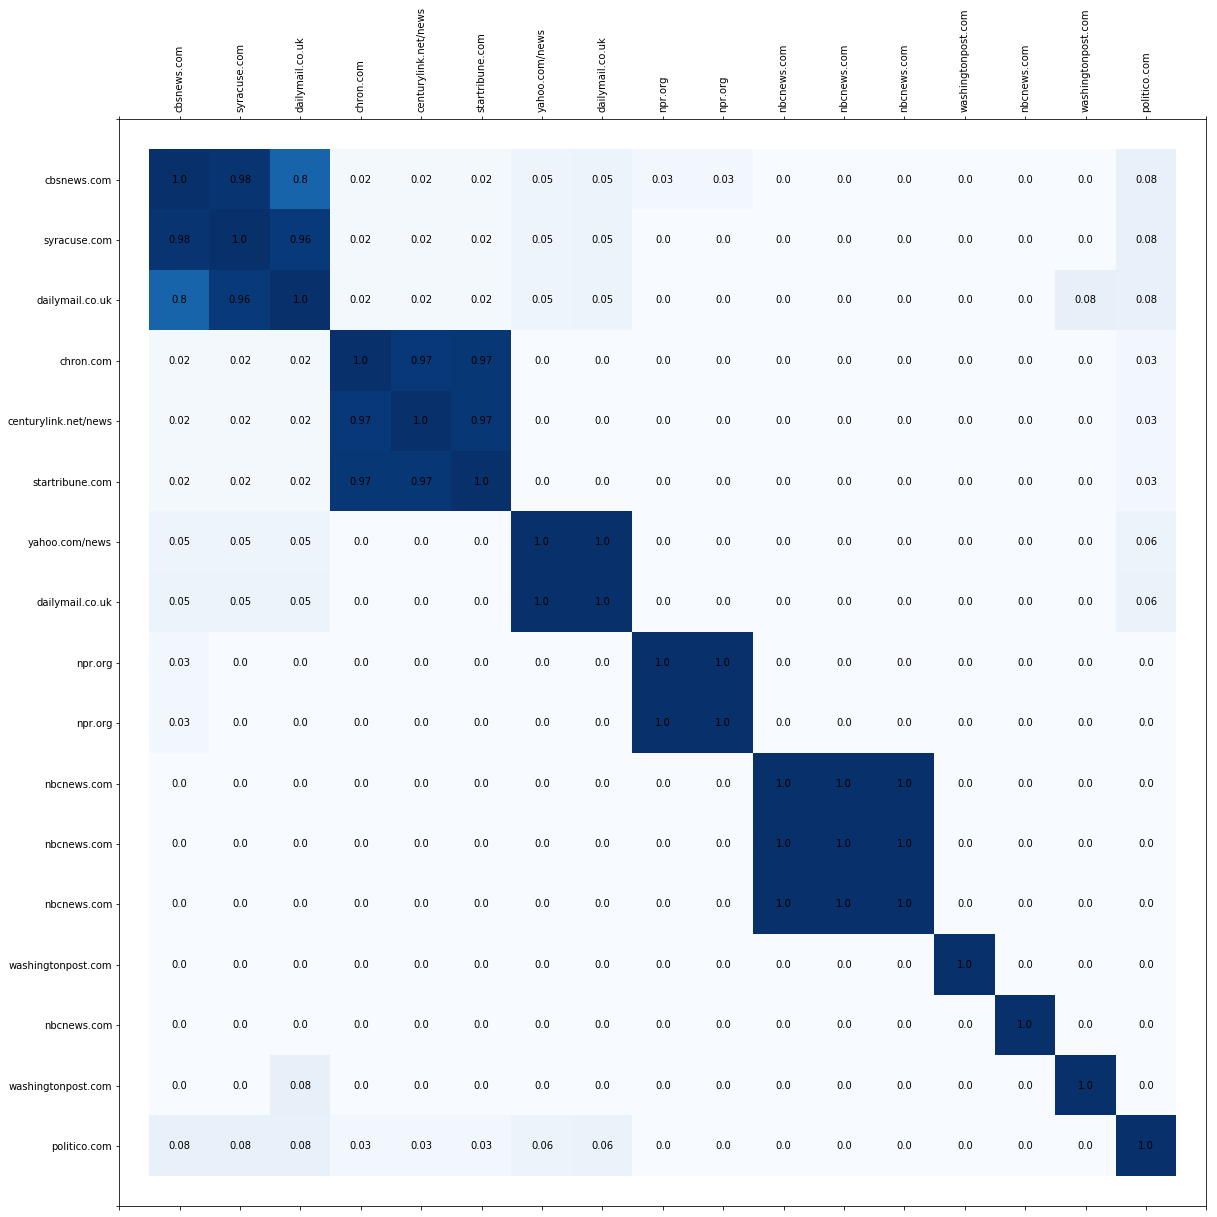

In [9]:
docs_list = clust_ap + clust_ap_files + clust_reuters + clust_freshair + clust_levinson + clust_wrong + [8985, 1766]
# 8985 = briefing of many news stories, includes snippet from 6844
# 1766 = heavily based off of reuters 
clusters_dict = dict_by_ids(census_df, docs_list)

score_mat = ac.jac_score_mat(clusters_dict)
axislabels = [census_df[census_df["id"] == id].iloc[0, 1] for id in docs_list]
ac.display_mat(score_mat, True, axislabels)

0 / 24 done, 0.0 seconds elapsed
5 / 24 done, 4.28 seconds elapsed
10 / 24 done, 5.27 seconds elapsed
12 / 24 done, 5.51 seconds elapsed
17 / 24 done, 6.05 seconds elapsed
22 / 24 done, 6.7 seconds elapsed


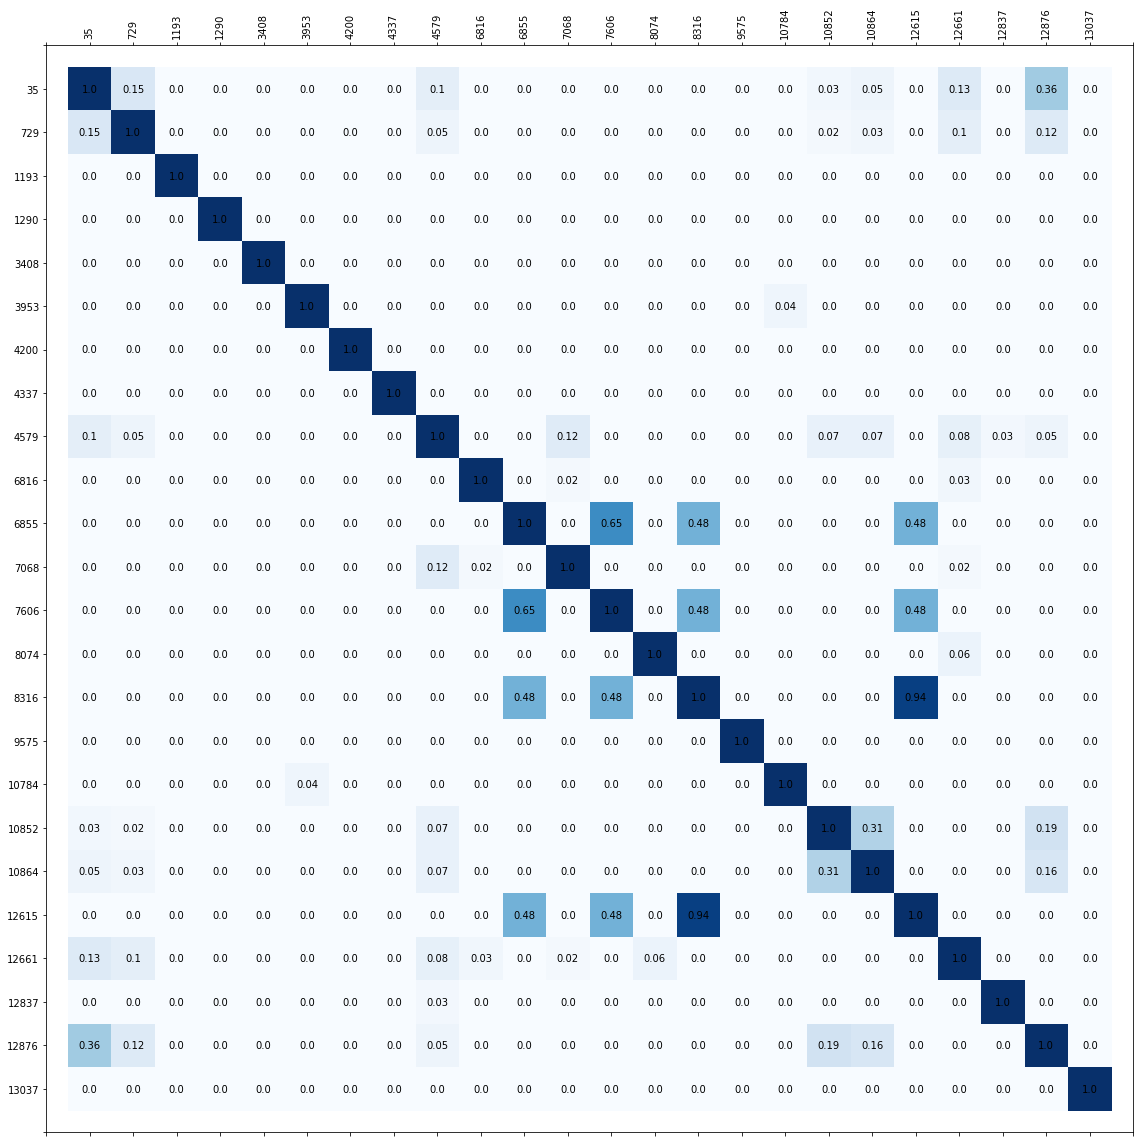

In [10]:
dm_ids = helsinki_df.loc[(helsinki_df["publisher"] == "dailymail.co.uk"), "id"]
dm_dict = dict_by_ids(helsinki_df, dm_ids)

score_mat_dm = ac.jac_score_mat(dm_dict)
axislabels = list(dm_dict.keys())
ac.display_mat(score_mat_dm, True, axislabels)

# 35, 729, and 12876 contain similar snippets as they are all news-in-summary type articles
# 6855, 7606 have a score of .61; are both very short articles sharing similar sentences 
# 6855, 8316[12615] have score .25[.29]; contains many short sentences (captions?) that are in 6855
# 8316, 12615 .86,  same article 
# 10864, 10852 have score .25, same topic, different articles but some shared sentences (esp. photo captions)

Example of a 0.31 pairwise article similarity

S 0 : Sunday, Jul 15th 2018 5-Day Forecast 

	T 0 1.0 : Sunday, Jul 15th 2018 5-Day Forecast 

S 3 :  The U.S. homeland security secretary says there are no signs Russia is targeting the 2018 midterm elections for cyberattacks with the "scale and scope" it used in 2016. 

	T 2 0.5 :  PHILADELPHIA (AP) - The U.S. homeland security secretary said on Saturday there are no signs that Russia is targeting this year's midterm elections with the same "scale or scope" it targeted the 2016 presidential election. 

S 4 :  U.S. Department of Homeland Security Secretary Kirstjen Nielsen addresses a convention of state secretaries of state, Saturday, July 14, 2018, in Philadelphia. 

	T 7 1.0 :  U.S. Department of Homeland Security Secretary Kirstjen Nielsen addresses a convention of state secretaries of state, Saturday, July 14, 2018, in Philadelphia. 

S 5 : Nielsen told the gathering that there are no signs that Russia is targeting this year's midter

0.321712292002147

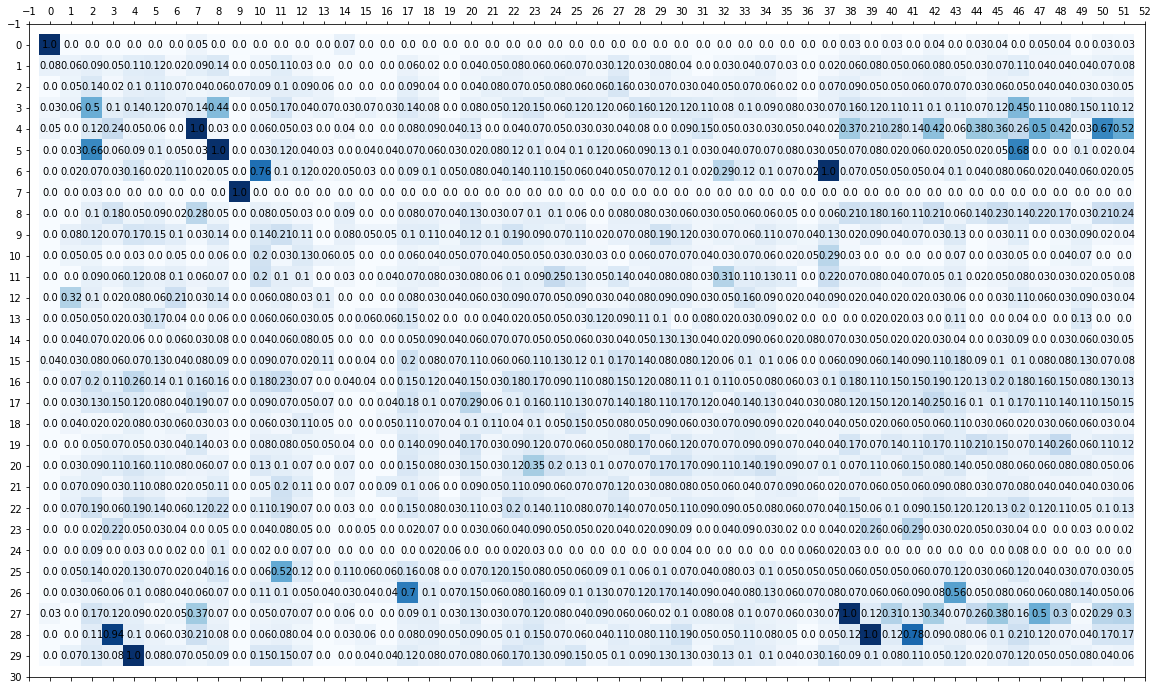

In [11]:
id1 = 10864
id2 = 10852
print("Example of a 0.31 pairwise article similarity\n")
ac.get_match_matrix(dm_dict[id1], dm_dict[id2])
ac.display_mat(ac.get_jaccard_matrix())
ac.print_sentence_matches()
ac.jaccard_score()

In [12]:
"""
for (i, doc) in dm_dict.items():
    print(i, "\n")
    print(doc, "\n\n")
"""

'\nfor (i, doc) in dm_dict.items():\n    print(i, "\n")\n    print(doc, "\n\n")\n'

0 / 25 done, 0.0 seconds elapsed
3 / 25 done, 0.86 seconds elapsed
5 / 25 done, 2.65 seconds elapsed
8 / 25 done, 3.42 seconds elapsed
10 / 25 done, 3.5 seconds elapsed
13 / 25 done, 4.06 seconds elapsed
15 / 25 done, 4.29 seconds elapsed
18 / 25 done, 4.55 seconds elapsed
20 / 25 done, 4.64 seconds elapsed
23 / 25 done, 4.71 seconds elapsed


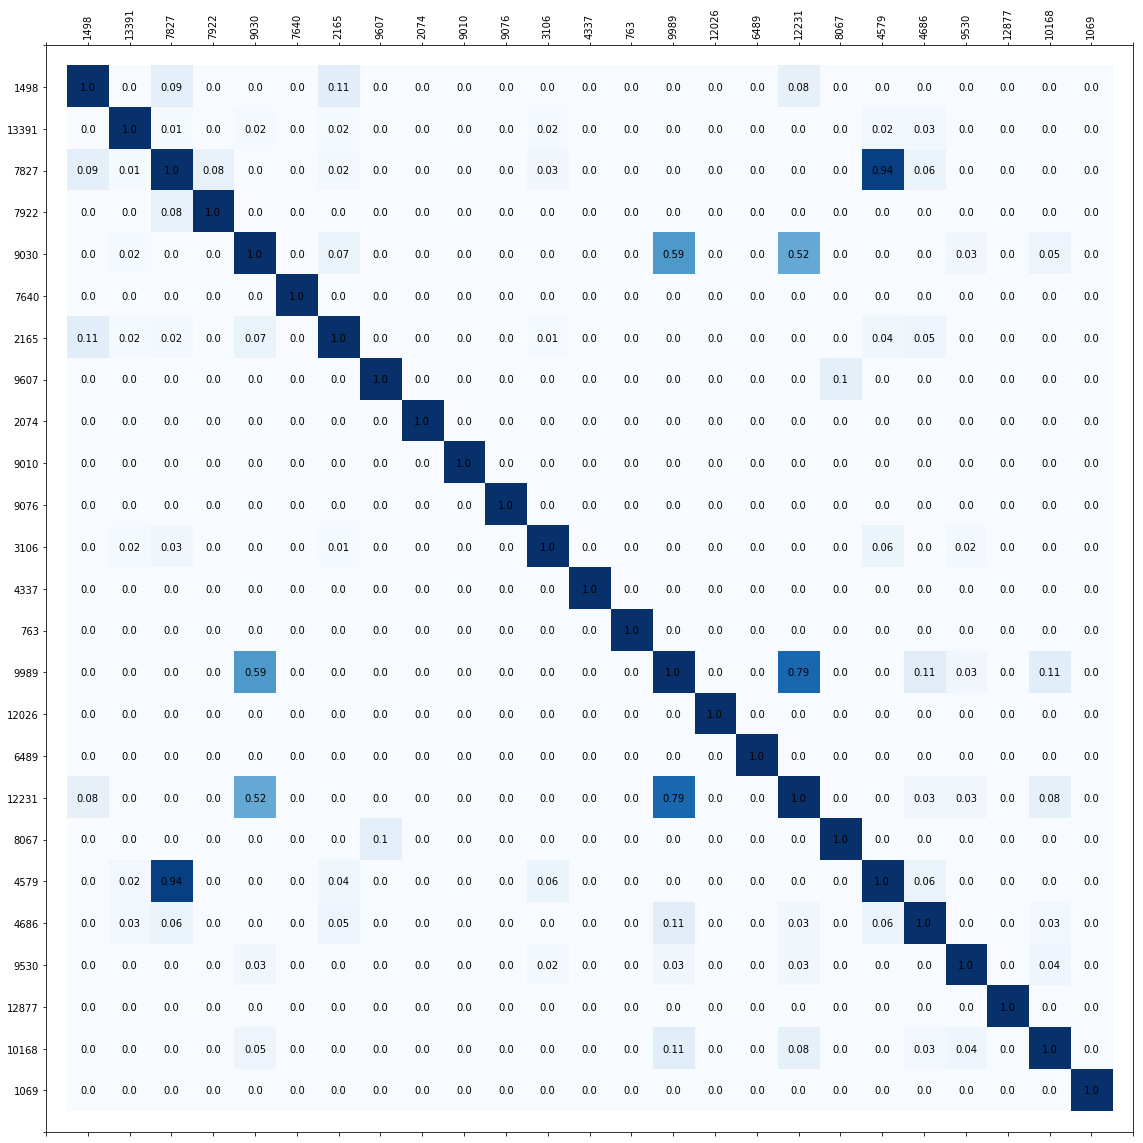

In [13]:
#rand_ids = random.sample(list(helsinki_df["id"]), 25)
rand_ids = [1498, 13391, 7827, 7922, 9030, 7640, 2165, 9607, 
            2074, 9010, 9076, 3106, 4337, 763, 9989, 12026, 6489, 
            12231, 8067, 4579, 4686, 9530, 12877, 10168, 1069]
helsinki_dict = dict_by_ids(helsinki_df, rand_ids)

score_mat_helsinki = ac.jac_score_mat(helsinki_dict)
axislabels = list(helsinki_dict.keys())
ac.display_mat(score_mat_helsinki, True, axislabels)

# articles 7827, 4579 are the same article with the exception of an additional few paras
# articles 9030, 9989, 12231 all share copied paragraphs, but also different follow-up paragraphs 

Example of a 0.79 pairwise article similarity

S 9 :  HELSINKI (AP) — President Donald Trump and Vladimir Putin opened their summit Monday with serious expression all around and the American president declaring that "the world wants to see us get along." 

	T 3 0.93 :  President Donald Trump and Vladimir Putin opened their summit Monday with serious expression all around and the American president declaring that "the world wants to see us get along." 

S 10 :  Trump laid out a list of topics for discussion that notably did not include Russian meddling in the 2016 presidential election. 

	T 4 1.0 : Trump laid out a list of topics for discussion that notably did not include Russian meddling in the 2016 presidential election. 

S 11 :  "We have not been getting along well for the last number of years," Trump said as he and Putin sat down at the Presidential Palace in Finland's capital. 

	T 5 1.0 :  "We have not been getting along well for the last number of years," Trump said as he and 

0.7886904761904763

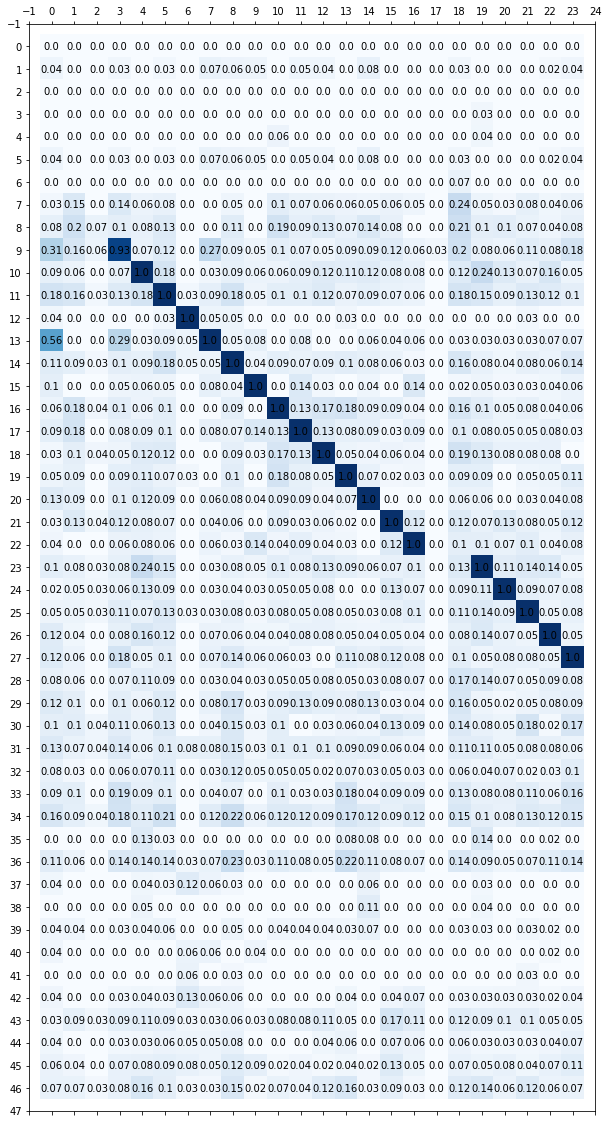

In [14]:
id1 = 12231
id2 = 9989
print("Example of a 0.79 pairwise article similarity\n")
ac.get_match_matrix(helsinki_dict[id1], helsinki_dict[id2])
ac.display_mat(ac.get_jaccard_matrix())
ac.print_sentence_matches()
ac.jaccard_score()

Text(0.5, 1.0, 'Probability density histogram of pairwise article similarity scores\n for non-zero similarities')

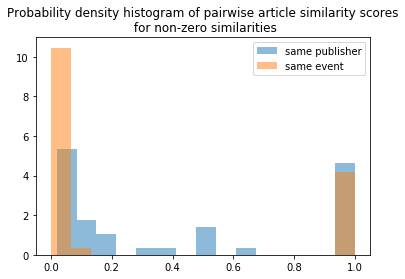

In [15]:
hist(score_mat_dm[np.where(score_mat_dm > 0)])
hist(score_mat_helsinki[np.where(score_mat_dm > 0)])
plt.legend(["same publisher", "same event"])
plt.title("Probability density histogram of pairwise article similarity scores\n for non-zero similarities")

0 / 24 done, 0.0 seconds elapsed
5 / 24 done, 4.24 seconds elapsed
10 / 24 done, 5.36 seconds elapsed
12 / 24 done, 5.59 seconds elapsed
17 / 24 done, 6.1 seconds elapsed
22 / 24 done, 6.75 seconds elapsed
Unique articles:  23 / 24
With max similarity of 0.750000


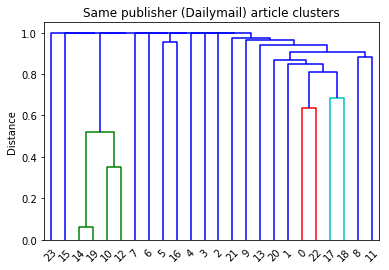

In [16]:
thresh_dist = 0.75
clusts = ac.get_article_clusters(dm_dict, thresh_dist, True)
plt.title("Same publisher (Dailymail) article clusters")
print("Unique articles: ", len(np.unique(clusts)), "/", len(clusts))
print("With max similarity of %f" % thresh_dist)

0 / 25 done, 0.0 seconds elapsed
3 / 25 done, 1.02 seconds elapsed
5 / 25 done, 2.57 seconds elapsed
8 / 25 done, 3.12 seconds elapsed
10 / 25 done, 3.18 seconds elapsed
13 / 25 done, 3.6 seconds elapsed
15 / 25 done, 3.73 seconds elapsed
18 / 25 done, 3.88 seconds elapsed
20 / 25 done, 3.94 seconds elapsed
23 / 25 done, 3.98 seconds elapsed
Unique articles:  23 / 25
With max similarity of 0.750000


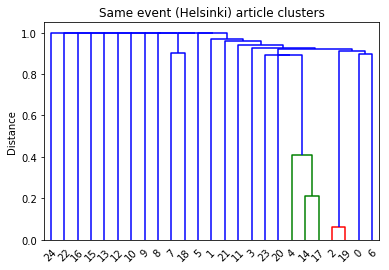

In [17]:
thresh_dist = 0.75
clusts = ac.get_article_clusters(helsinki_dict, thresh_dist, True)
plt.title("Same event (Helsinki) article clusters")
print("Unique articles: ", len(np.unique(clusts)), "/", len(clusts))
print("With max similarity of %f" % thresh_dist)

In [18]:
len(helsinki_dict)

25